### Notebook basics
- Jupyter notebook script consists of code (and markdown) cells, like this one for notes.
- You can run code cells either all together OR ONE at a time
- escape leaves a cell, then a creates a new one above and b creates a new one below
- to execute a shell press shift+enter
- to execute a shell and create a new one below press alt+enter
- to print a variable, you can either type print(variablename) or just type variablename
- In a variable assignment in Python, no need to declare type
- Use numpy (short for Numerical Python)  to create arrays (from lists, from class functions, from other objects) and operate upon  arrays


### Φορτώνουμε βιβλιοθήκες

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 8]
# in case you opened this file from the wrong directory
#import os  
#cwd=os.getcwd(); print(cwd)
#path='/Users/labuser...'
#os.chdir(path)


### Εισαγουμε μετρήσεις pixel vs. wavelength (από ds9)

In [16]:
# Example of pixel vs. wavelength measurements. The numbers here are random! 
#.please insert your own measurements instead

x=np.array([80,128,356,612,1366,1636])
y=np.array([2190,4026,4713,5048,6678,7281])# Angstrom
dy=0.1*y


### Προσαρμογή ευθείας με χ^2 - είτε με υπολογιστικό κώδικα

In [17]:
def ff(x,p0,p1): return p0+p1*x

from scipy.optimize import curve_fit

popt, pcov = curve_fit(ff, x, y, sigma=dy)
dpopt=np.sqrt(np.diag(pcov))
print(f"p0 = {popt[0]:.1f} +/- {dpopt[0]:.2f} , p1= {popt[0]:.1f} +/- {dpopt[0]:.2f}")

p0 = 2490.7 +/- 454.64 , p1= 2490.7 +/- 454.64


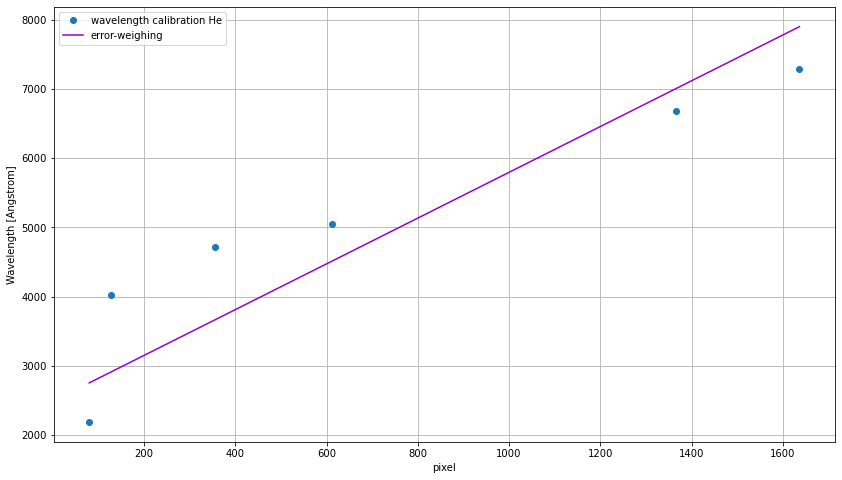

In [32]:
plt.plot(x,y,'o',label="wavelength calibration He")

plt.xlabel('pixel')
plt.ylabel('Wavelength [Angstrom]')

plt.plot(x,popt[0]+popt[1]*x,label='error-weighing',color='darkviolet')
plt.legend()
plt.grid()

### Εναλλακτική, αναλυτική μέθοδος χ^2

In [24]:
#αναλυτικό από ροπές
# Γραμμικό πρόβλημα, λυμμένο ήδη αναλυτικά με μέθοδο χ^2

# now with errors
m0=np.sum(y/(dy**2));  m1=np.sum(x*y/(dy**2))
s0=np.sum(x**0./dy**2); s1=np.sum(x**1./dy**2); s2=np.sum(x**2./dy**2)

p1=(m0/s0 - m1/s1)/(s1/s0-s2/s1)
p0=(m1-p1*s2)/s1

print(p0,p1)


2490.6695007396925 3.3041672374506517


### Now plot the stellar spectrum, as extracted

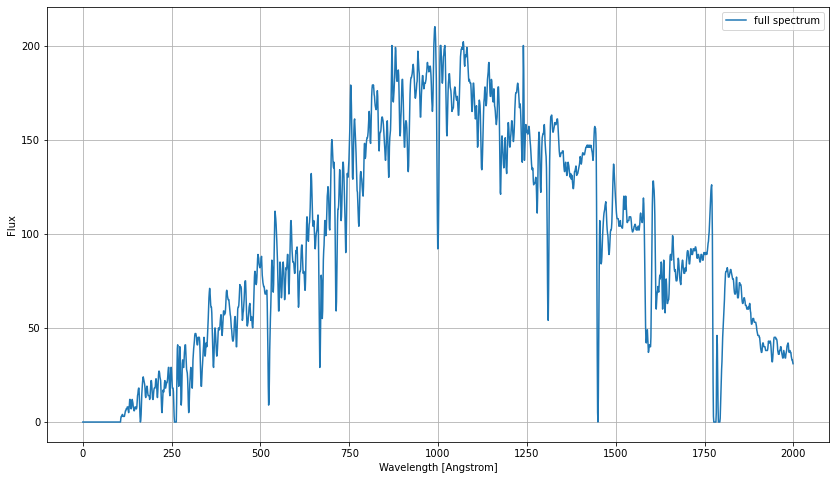

In [33]:
data = np.loadtxt('solar-spectrum-extracted.txt' ) # or however else you named your file

pixel=data[:,0]
flux=data[:,1]

plt.plot(pixel,flux,label="full spectrum")
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux')
plt.legend()
plt.grid()

### Convert pixels into Angstroms

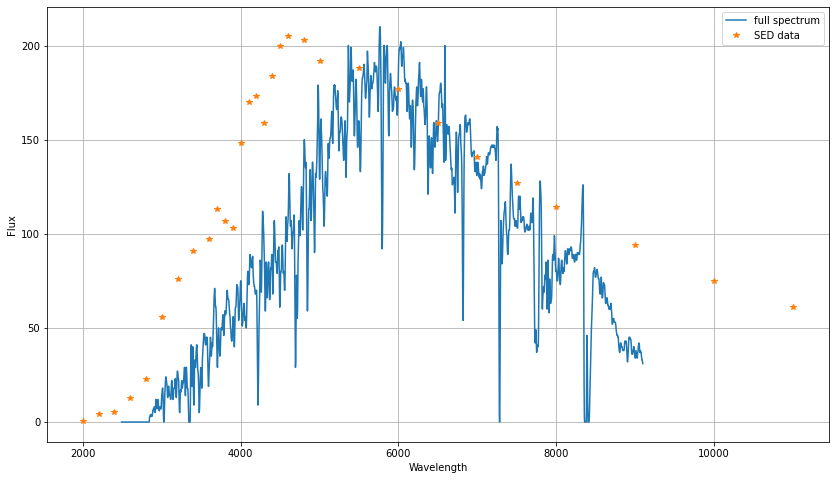

In [29]:
data = np.loadtxt('solar-spectrum-extracted.txt' ) # or however else you named your file

data[~np.isfinite(data)] = 0. # check is there is not-a-number anywhere. Tilda means the opposite

wavelength = p0+p1*pixel

plt.plot(wavelength,flux,label="full spectrum")
SED_data = np.loadtxt('solar-SED.txt' ) # or however else you named your file
plt.plot(SED_data[:,0],SED_data[:,1],'*',label='SED data')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.grid()

### Now compare to a galaxy's spectrum

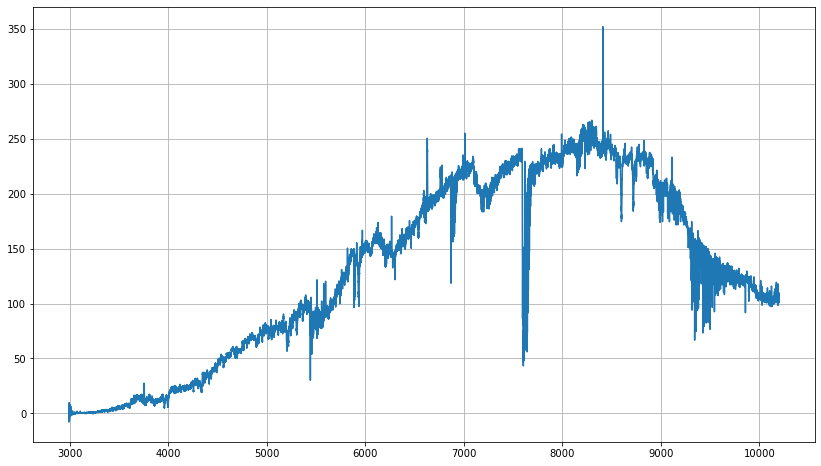

In [28]:
galaxy = np.loadtxt('galaxy_spectrum.txt' )
#np.savetxt('solar-spectrum-extracted-calibrated.txt',p0+p1*x,y,fmt='%.4e')
plt.plot(galaxy[:,0]*10.,galaxy[:,1]/30)
plt.grid()

# Blackbody Emission
## Planck's law of black-body radiation 
$$
B_{\nu}(T)=\frac{2 \nu^{2}}{c^{2}} \frac{h \nu}{e^{h \nu / k T}-1}
$$
where $\nu$ in the frequency, $h$ is the Planck constant, $c$ is the speed of light in a vacuum, $k$ is the Boltzmann constant and $T$ is the absolute temperature of the body.

Equating the integral of spectral radiance in per unit wavelength to that of per unit frequency
$$
\int_{\lambda_{1}}^{\lambda_{2}} B_{\lambda}(\lambda, T) d \lambda=\int_{\nu\left(\lambda_{2}\right)}^{\nu\left(\lambda_{1}\right)} B(\nu, T) d \nu=\int_{\lambda_{2}}^{\lambda_{1}} B(\nu, T) \frac{d \nu}{d \lambda} d \lambda=\int_{\lambda_{1}}^{\lambda_{2}}-B(\nu, T) \frac{d \nu}{d \lambda} d \lambda
$$

Because this equation holds for any limits
$$
B_{\lambda}(\lambda, T)=-B(\nu, T) \frac{d \nu}{d \lambda}
$$
and by using $c=\lambda \nu$,
$$
B_{\lambda}(\lambda, T)=\frac{2 h c^{2}}{\lambda^{5}} \frac{1}{e^{\frac{h c}{\lambda k_{\mathrm{B}} T}}-1}
$$

In [42]:
from scipy.integrate import simpson

In [57]:
simpson(SED_data[:,1],SED_data[:,0])/1e6

1.0223958333333334

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6.794117296062131e-05 2.812373849686566e+27
2.755045165604531e+41


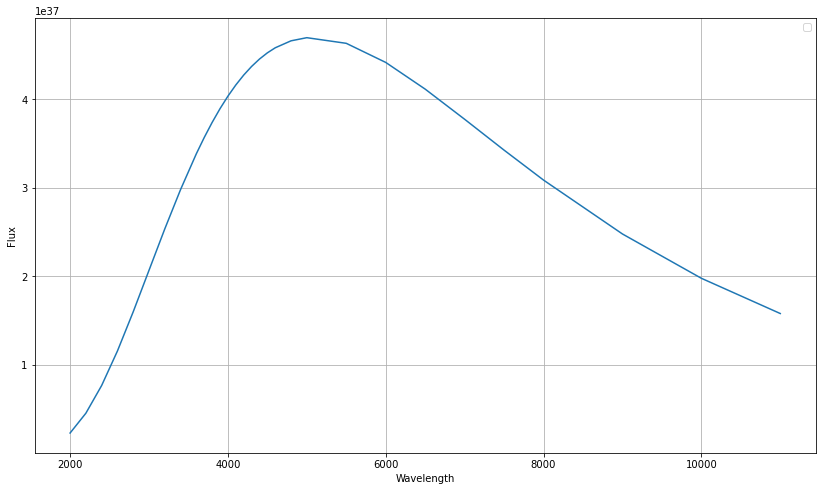

In [56]:

def black_body_luminosity(wavelength,T): #wavelength in Angstrom
    
    h,c, kb, = 6.626e-27 ,2.9979e10, 1.38e-16    #	erg/Hz, cm/s, erg/K
    #nu = c/(wavelength*1e-8)
    l=wavelength *1e-8 #wavelength in cm
    #B_lambda = 2*h*c**2/ wavelength**5/(np.exp(h*nu/(kb*T))-1) 
    B_lambda = 2*h*c**2/ l**5/(np.exp(h*c/(l*kb*T))-1) 
    
    return B_lambda # in erg/s/Angstrom/cm^2/sr from the emitting object's surface

def solar_black_body_luminosity(wavelength,T,R,D):
    Omega= 2*np.pi*(1-np.sqrt(D**2-R**2)/D) #sr
    d_mod=4*np.pi*D**2 #cm^2
    print(Omega,d_mod)
    return Omega*d_mod*black_body_luminosity(wavelength,T) # in erg/s/Angstrom

planck= black_body_luminosity(SED_data[:,0],5700.) 

solar_luminosity = solar_black_body_luminosity(SED_data[:,0],5700,6.957e10,1.496e13)
print(simpson(solar_luminosity,SED_data[:,0]))
#plt.plot(SED_data[:,0],planck )
plt.plot(SED_data[:,0],solar_luminosity )
#plt.plot(SED_data[:,0],SED_data[:,1],'*',label='SED data')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.grid()
